In [26]:
!pip install tensorflow_datasets
!pip install tensorflow-text

In [103]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [27]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']


In [28]:
for example_pr, example_en in train_examples.batch(4).take(1):
    for pt in example_pr.numpy():
        print(pt.decode("utf-8"))
        
    print()
    
    for en in example_en.numpy():
        print(en.decode("utf-8"))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .


In [29]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

tokenizers = tf.saved_model.load(model_name)


[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [30]:
for en in example_en.numpy():
  print(en.decode('utf-8'))
  
  
encoded=tokenizers.en.tokenize(example_en)

for row in encoded.to_list():
    print(row)
    
    
detokenizer=tokenizers.en.detokenize(encoded)

for line in detokenizer.numpy():
    print(line.decode('utf-8'))
    
    
token=tokenizers.en.lookup(encoded)

token

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]
[2, 72, 81, 2508, 2159, 3072, 1282, 80, 192, 45, 13, 100, 111, 6040, 3176, 3186, 13, 94, 235, 89, 1938, 15, 3]
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]'], [b'[START]', b'and', b'this', b'conscious', b'de', b'##fi', b'##ance', b'is', b'why', b'i', b',', b'as', b'an', b'ag', b'##no', b'##stic', b',', b'can', b'still', b'have', b'faith', b'.', b'[END]']]>

In [31]:
def tokenize_pairs(en,pt):
    pt=tokenizers.pt.tokenize(pt)
    #convert ragged to dense by adding padding with zero
    pt=pt.to_tensor()
    
    en=tokenizers.en.tokenize(en)
    en=en.to_tensor()
    
    return en, pt

In [32]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [33]:
def make_batches(ds):
    return(
    ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE))


In [34]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [35]:
print(train_batches)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>


# Positional Encoding:
Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other.But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

In [36]:
### optional
print(np.arange(3))
### np.newaxis
print("====newaxis====")
print(np.arange(10)[:,np.newaxis])
pos=np.arange(10)[:,np.newaxis]

[0 1 2]
====newaxis====
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]


In [37]:
## optional
i=np.arange(5)[np.newaxis, :]
np.arange(5)[np.newaxis, :]

array([[0, 1, 2, 3, 4]])

In [38]:
## optional 
angle_rads=pos/np.power(1000,(2*i)/np.float32(5))
pos/np.power(1000,(2*i)/np.float32(5))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 6.30957344e-02, 3.98107171e-03, 2.51188643e-04,
        1.58489319e-05],
       [2.00000000e+00, 1.26191469e-01, 7.96214341e-03, 5.02377286e-04,
        3.16978638e-05],
       [3.00000000e+00, 1.89287203e-01, 1.19432151e-02, 7.53565929e-04,
        4.75467958e-05],
       [4.00000000e+00, 2.52382938e-01, 1.59242868e-02, 1.00475457e-03,
        6.33957277e-05],
       [5.00000000e+00, 3.15478672e-01, 1.99053585e-02, 1.25594322e-03,
        7.92446596e-05],
       [6.00000000e+00, 3.78574407e-01, 2.38864302e-02, 1.50713186e-03,
        9.50935915e-05],
       [7.00000000e+00, 4.41670141e-01, 2.78675019e-02, 1.75832050e-03,
        1.10942523e-04],
       [8.00000000e+00, 5.04765876e-01, 3.18485736e-02, 2.00950915e-03,
        1.26791455e-04],
       [9.00000000e+00, 5.67861610e-01, 3.58296453e-02, 2.26069779e-03,
        1.42640387e-04]])

In [39]:
## optional
angle_rads[:,0::2] = np.sin(angle_rads[:, 0::2])
angle_rads[:,0::2]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.41470985e-01,  3.98106119e-03,  1.58489319e-05],
       [ 9.09297427e-01,  7.96205928e-03,  3.16978638e-05],
       [ 1.41120008e-01,  1.19429312e-02,  4.75467958e-05],
       [-7.56802495e-01,  1.59236138e-02,  6.33957277e-05],
       [-9.58924275e-01,  1.99040441e-02,  7.92446595e-05],
       [-2.79415498e-01,  2.38841589e-02,  9.50935914e-05],
       [ 6.56986599e-01,  2.78638951e-02,  1.10942523e-04],
       [ 9.89358247e-01,  3.18431897e-02,  1.26791455e-04],
       [ 4.12118485e-01,  3.58219797e-02,  1.42640387e-04]])

In [40]:
## optional
np.power(3, (2 * (i//2)))

array([[ 1,  1,  9,  9, 81]], dtype=int32)

In [41]:
def get_angle(pos, i,d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [42]:
def positional_encoding(position,d_model):
    angle_rads=get_angle(np.arange(position)[:,np.newaxis],np.arange(d_model)[np.newaxis, :],d_model )
    angle_rads[:,0::2]=np.sin(angle_rads[:,0::2])
    
    angle_rads[:,1::2]=np.cos(angle_rads[:,1::2])
    
    pos_encoding=angle_rads[np.newaxis,...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)
    

(1, 2048, 512)


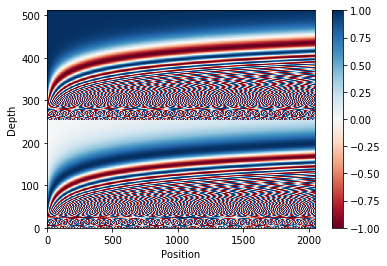

In [43]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Masking
Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [44]:
## optional what tf.cast function do?
x = tf.constant([1.8, 2.2], dtype=tf.float32)
tf.cast(x, tf.int32)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2])>

In [45]:
x = tf.constant([2, 4])
y = tf.constant(2)
tf.math.equal(x, y)

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True, False])>

In [46]:
def create_padding_mask(seq):
    seq=tf.cast(tf.math.equal(seq,0),tf.float32)
    return seq[:,tf.newaxis,tf.newaxis,:]

In [47]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

# look-ahead mask
It is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

In [48]:
### optional
input=tf.constant([[ 0,  1,  2, 3],
              [-1,  0,  1, 2],
              [-2, -1,  0, 1],
               [-3, -2, -1, 0]])

 #tf.linalg.band_part(input, 0, -1) ==> Upper triangular part.
 #tf.linalg.band_part(input, -1, 0) ==> Lower triangular part.
 #tf.linalg.band_part(input, 0, 0) ==> Diagonal.
tf.linalg.band_part(input, -1, 0)    

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 0,  0,  0,  0],
       [-1,  0,  0,  0],
       [-2, -1,  0,  0],
       [-3, -2, -1,  0]])>

In [49]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [25]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Scaled dot product attention
The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:
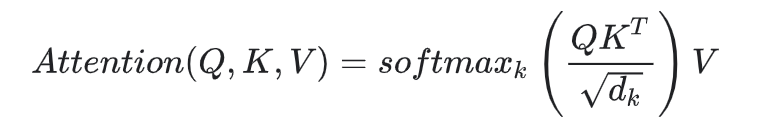

The dot-product attention is scaled by a factor of square root of the depth. 

*** This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

In [50]:
## optional
softmax = tf.nn.softmax([-1, 0., 1.])
softmax

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09003057, 0.24472848, 0.66524094], dtype=float32)>

In [51]:
sum(softmax)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [92]:
def scaled_dot_product_attention(q,k,v,mask):
    
    matmul_qk=tf.matmul(q,k,transpose_b=True)
    
    ### depth: key.shape
    depth=tf.shape(k)[-1]

    dk=tf.cast(depth,tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits+=(mask* -1e9)
        
    ###As the softmax normalization is done on K, its values decide the amount of importance given to Q.
    attention_weight= tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    #The output represents the multiplication of the attention weights and the V (value) vector. 
    #This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.
    output=tf.matmul(attention_weight,v)
    
    return output, attention_weight

In [93]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [94]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

In [95]:
# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [96]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [97]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [98]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# Multi-head attention
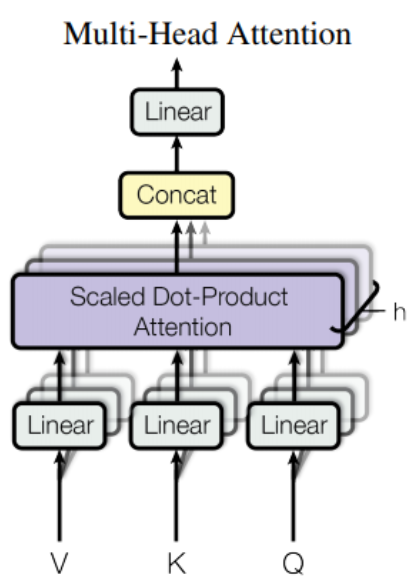

Multi-head attention:- it consist four parts:
1. Linear layers and split into heads
2. Scaled dot product
3. Concatenation of heads
4. Final linear layer

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The scaled_dot_product_attention defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using tf.transpose, and tf.reshape) and put through a final Dense layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.



In [99]:
class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)
    
   def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Create a MultiHeadAttention layer to try out. At each location in the sequence, y, the MultiHeadAttention runs all 8 attention
heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [100]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point wise feed forward network
Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [101]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [102]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# Encoder and decoder
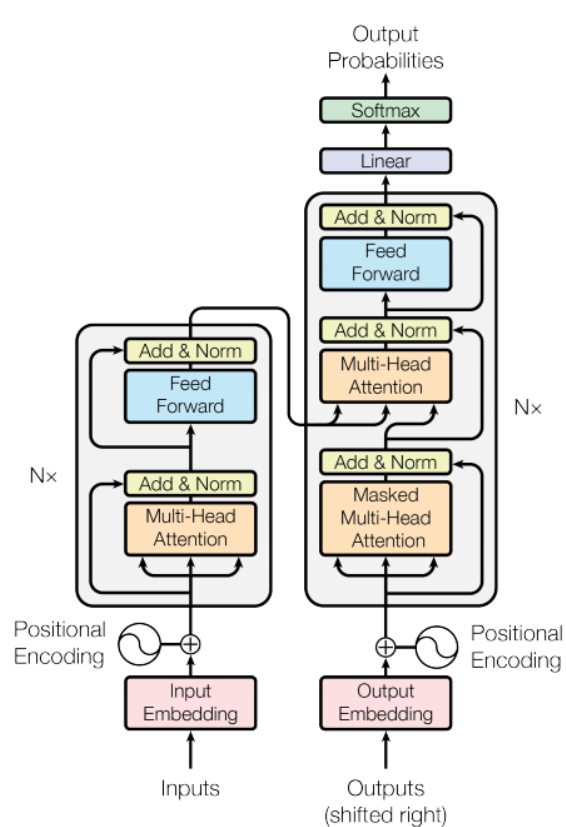

The transformer model follows the same general pattern as a standard sequence to sequence with attention model.

The input sentence is passed through N encoder layers that generates an output for each word/token in the sequence.
The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.
Encoder layer
Each encoder layer consists of sublayers:

Multi-head attention (with padding mask)
Point wise feed forward networks.
Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis. There are N encoder layers in the transformer.


In [104]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [105]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])